In [1]:
from typing import List, Mapping
from itertools import zip_longest

import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
import abel

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_to_drdomega, transpose_to_drdth,
)

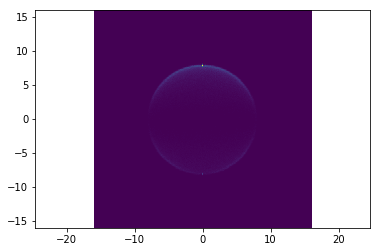

In [2]:
# Generate dist
def init_dist(beta: List[float], n: int = 1001) -> Mapping[str, np.ndarray]:
    x = np.linspace(-1, 1, n)
    fx = Legendre([1, *beta])(x)
    return {
        'x': x,
        'px': fx / fx.sum(),
    }


beta = [1, 1.5, 0.5, -0.5]
dist = init_dist(beta)


# Generate samples
def init_smp(
    n: int, r: float, sigma: float, x: float, px: float,
) -> Mapping[str, np.ndarray]:
    r = normal(loc=r, scale=sigma, size=n)
    z = r * choice(x, p=px, size=n)
    phi = 2 * np.pi * rand(n)
    x = (r ** 2 - z ** 2) ** 0.5 * np.cos(phi)
    y = (r ** 2 - z ** 2) ** 0.5 * np.sin(phi)
    return {
        'x': x,
        'y': y,
        'z': z,
    }


smp = init_smp(n=1000000, r=8, sigma=0.1, **dist)

# Generate projected image from the samples
xedges = np.linspace(-16, 16, 641)
zedges = np.linspace(-16, 16, 321)
img, *_ = np.histogram2d(smp['x'], smp['z'], bins=[xedges, zedges])

plt.figure()
plt.pcolormesh(xedges, zedges, img.T)
plt.axis("equal")
plt.show()

Loading basis sets...
Cached basis file incompatible.
A suitable basis set was not found.
A new basis set will be generated.
This may take a few minutes.
But don't worry, it will be saved to disk for future use.
Generating horizontal BASEX basis sets for n = 320, sigma = 1.0 (nbf = 320):
k = 0...50...100...150...200...250...300...320
Basis set saved for later use to
  basex_basis_320_1.0.npy
Updating regularization...
Calculating correction...
Using memory-cached basis sets
Using memory-cached basis sets
Using memory-cached basis sets


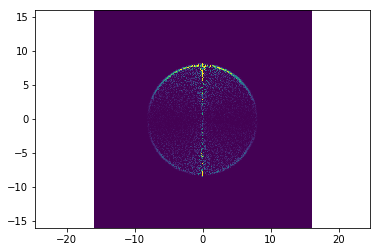

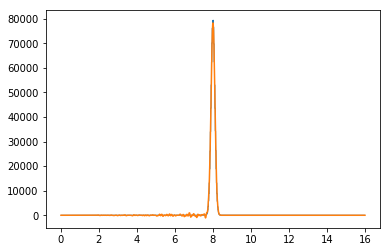

Expected   Simulated
--------   ---------
   1.000       1.018
   1.500       1.554
   0.500       0.557
  -0.500      -0.356
   0.000       0.108


In [10]:
# Abel invert the image using PyAbel
dx = xedges[1:] - xedges[:-1]
inverted = abel.Transform(img.T, direction="inverse", method="basex").transform.T / dx[:, None]  # shape: (rho, z)

plt.figure()
plt.pcolormesh(xedges, zedges, inverted.T)
plt.axis("equal")
plt.clim(0, 100)
plt.show()

# Transpose to other spaces
sliced = interp(inverted, xedges, zedges)  # (rho, z) -> intensity
redges, thedges = np.linspace(0, 16, 801), np.linspace(-np.pi, np.pi, 721)
hist_indrdomega = tohist(
    transpose_to_drdomega(sliced), redges, thedges,
)  # (r, th) -> intensity
hist_indrdth = tohist(
    transpose_to_drdth(sliced), redges, thedges,
)  # (r, th) -> intensity
_, coeff, _ = finite_legendre_transform_in_theta(
    hist_indrdomega.sum(0), thedges, 6,
)  # Shapes of returns: (n, r) (n, r) (n, th)

plt.figure()
plt.hist(np.linalg.norm([smp["x"], smp["y"], smp["z"]], axis=0), redges, histtype="step")
plt.plot((redges[1:] + redges[:-1]) / 2, hist_indrdth.sum(1))
plt.show()

print("Expected   Simulated")
print("--------   ---------")
for expected, simulated in zip_longest(beta, coeff[1:]/coeff[0]):
    print(f"{expected if expected else 0:>8.3f}   {simulated:>9.3f}")

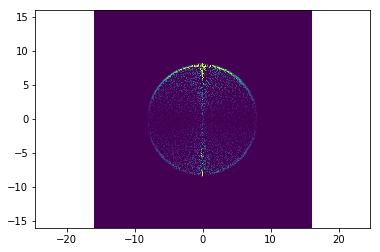

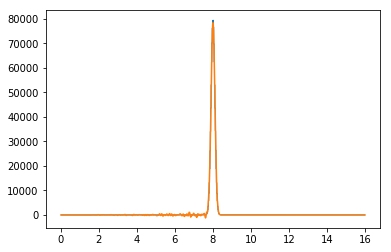

Expected   Simulated
--------   ---------
   1.000       1.009
   1.500       1.527
   0.500       0.522
  -0.500      -0.426
   0.000       0.048


In [9]:
# Abel invert the image using vmitools
dx = xedges[1:] - xedges[:-1]
inverted = abel_inverse(img, xedges) * dx[:, None]  # shape: (rho, z)

plt.figure()
plt.pcolormesh(xedges, zedges, inverted.T)
plt.axis("equal")
plt.clim(0, 100)
plt.show()

# Transpose to other spaces
sliced = interp(inverted, xedges, zedges)  # (rho, z) -> intensity
redges, thedges = np.linspace(0, 16, 801), np.linspace(-np.pi, np.pi, 721)
hist_indrdomega = tohist(
    transpose_to_drdomega(sliced), redges, thedges,
)  # (r, th) -> intensity
hist_indrdth = tohist(
    transpose_to_drdth(sliced), redges, thedges,
)  # (r, th) -> intensity
_, coeff, _ = finite_legendre_transform_in_theta(
    hist_indrdomega.sum(0), thedges, 6,
)  # Shapes of returns: (n, r) (n, r) (n, th)

plt.figure()
plt.hist(np.linalg.norm([smp["x"], smp["y"], smp["z"]], axis=0), redges, histtype="step")
plt.plot((redges[1:] + redges[:-1]) / 2, hist_indrdth.sum(1))
plt.show()

print("Expected   Simulated")
print("--------   ---------")
for expected, simulated in zip_longest(beta, coeff[1:]/coeff[0]):
    print(f"{expected if expected else 0:>8.3f}   {simulated:>9.3f}")